<a href="https://colab.research.google.com/github/Raoufmamedov/HH.ru-parsing/blob/main/Parsing_HH_2.0_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ЦЕЛЬ РАБОТЫ: Парсинг сайта HH.ru для изучения распределения вакансий по уровню позиции и ожидаемому опыту кандидата.

In [ ]:
from collections import OrderedDict
import re
import string
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.feature_extraction.text import CountVectorizer
from pprint import pprint  # Импортируем функцию pprint()
import json
import requests
import pytz
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from datetime import datetime
from IPython.display import Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
# import chardet
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# from sklearn.linear_model import LogisticRegression
warnings.simplefilter(action='ignore', category=FutureWarning)


### Парсинг и сохранение данных

Проведём парсинг страниц по запросу Data Scientist с извлечением текстовой информации из раздела 'main', создавая словарь описаний по страницам и далее объединяя его содержимое в единый список.

In [ ]:
BSMPDict = dict()
page = 0
while page < 100:
    url = f"https://hh.ru/vacancies/data-engineer?page={page}"
    BSMPDict[str(page)] = BeautifulSoup(
        requests.get(url, headers={
            'User-Agent': 'Mozilla/5.0'
        }).text,
        'html.parser',
        # from_encoding='Windows-1251'
    )
    page = page + 1

In [ ]:
list_of_vacs = []
for dic in BSMPDict:
    for doc in [*BSMPDict[dic].find_all('main')]:
        list_of_vacs.append(doc.get_text(separator=' ', strip=True))
# ct = datetime.now(pytz.timezone('Europe/Moscow')).strftime("%d.%m.%y %H:%M")

In [ ]:
char_tran = str.maketrans({'\xa0':' ', '\u202f':' ', '\x98': ' ',
                           '\u20bd':'RUR', '\uff08':'(',
                           '\uff09':')', '\xe9':'e'})

list_of_vacs_clear = [str(vac).translate(char_tran) for vac in list_of_vacs]

Очищаем текст от невидимых пробельных символов, преобразуем списки со страниц в единую строку

In [ ]:
listofvacs_clear = [i.replace("\xa0", " ") for i in list_of_vacs]
listofvacs_clear = [i.replace("\u202f", " ") for i in listofvacs_clear]
listofvacs_clear = [i.replace("\u20bd", "RUR") for i in listofvacs_clear]
listofvacs_clear = [i.replace("\uff08", "(") for i in listofvacs_clear]
listofvacs_clear = [i.replace("\uff09", ")") for i in listofvacs_clear]
listofvacs_clear = [i.replace("\xe9", "e") for i in listofvacs_clear]
listofvacs = listofvacs_clear
listofvacs = " ".join(listofvacs)

Построим кривую распределения слов в строке и найдём 50 самых популярных.

In [ ]:
cnt = Counter(listofvacs.split(' '))
df = pd.DataFrame(cnt, index=['Freq']).T
df.sort_values(by='Freq', ascending=False, inplace=True)

In [ ]:
df.head(50).index

Index(['Москва', 'Откликнуться', 'Опыт', 'лет', '3-6', 'года', '1-3', 'Можно',
       'удалённо', 'Data', '•', 'и', 'еще', 'Engineer', '000', 'Работодатель',
       'онлайн', 'в', 'RUR', '6', '2', 'ООО', 'более', 'на', 'до', '1', 'руки',
       '–', 'Откликнитесь', 'среди', 'первых', 'Senior', 'Без', 'engineer',
       'опыта', 'вычета', 'налогов', 'инженер', 'За', 'график', 'занятость',
       'работа', 'Инженер', 'Digital', 'компании', 'для', 'Сбер', 'экспертов',
       '/', 'Scientist'],
      dtype='object')

Как мы видим в тексте много повторяющихся и не имеющих ценности для нашего исследования слов. Мы будем избавляться от них по мере необходимости, поскольку некоторые из них являются естественнными разделителями текста

In [ ]:
df.reset_index(names='Word')
# (set_index('Word').plot(

,Word,Freq
0,Москва,1790
1,Откликнуться,1772
2,Опыт,1730
3,лет,1102
4,3-6,952
...,...,...
2013,(Анализ,1
2014,АСК,1
2015,Java-разработчик/Проект,1
2016,WebGears,1


In [ ]:
df[:65].items

<bound method DataFrame.items of               Freq
Москва        1790
Откликнуться  1772
Опыт          1730
лет           1102
3-6            952
...            ...
три             40
Вахтовый        40
Удаленная       40
последние       40
дня             40

[65 rows x 1 columns]>

Мы ожидаемо видим:
1) слова присутствующие во всех или почти всех вакансиях (Москва, откликнуться)
2) ряд слов имеющих равную частотность и представляющих собою cловосочетания (например "Работодатель онлайн", "без опыта"). Некоторые из них мы далее удалим как неинформативные (например тот же "Работодатель онлайн"), добавив их в стоп-лист,а остальные оставим как есть или преобразуем.

Для фиксации текущего состояния нашего корпуса с описаниями вакансий, сохраним список в текстовый файл

Сохраняем спарсенный текст в текстовой файл и посмотрим что у нас получилось

In [ ]:
# Модуль сохранения спарсенного текста
def vac_desc_dumper(list_to_dump, timestamp=True):
    if timestamp:
        ct = datetime.now(
            pytz.timezone('Europe/Moscow')).strftime("%d.%m.%y %H:%M")
        print(listofvacs, file=open('hh_ru_mul(' + ct + ').txt', 'w'))
    else:
        print(listofvacs, file=open('hh_ru_mul.txt', 'w'))

In [ ]:
from pprint import pprint
pprint(listofvacs[:5000])

('Старший инженер (Wi-Fi) Опыт 3-6 лет Опыт 3-6 лет ООО ВсеИнструменты.ру '
 'Москва Москва Откликнуться Откликнуться TeamLead Data Engineer Опыт 3-6 лет '
 'Опыт 3-6 лет ООО HeadHunter::Infrastructure engineers Москва Алексеевская '
 'Москва • Алексеевская Откликнуться Откликнуться По вашему запросу ещё будут '
 'появляться новые вакансии. Присылать вам? data engineer Москва Ключевые '
 'слова в названии вакансии, в названии компании и в описании вакансии Да, на '
 'почту В мессенджер Frontend разработчик (React) Опыт 1-3 года Опыт 1-3 года '
 'билайн: ИТ, Data, Digital • Работодатель онлайн Москва Москва Работодатель '
 'онлайн Откликнуться Откликнуться Junior Python Developer Без опыта Можно '
 'удалённо Без опыта Можно удалённо ТОО Improvado KZ Москва Москва '
 'Откликнуться Откликнуться Backend разработчик (Java) 130 000 – 160 000 RUR '
 'до вычета налогов Опыт 1-3 года 130 000 – 160 000 RUR до вычета налогов Опыт '
 '1-3 года ООО Снэп АйТи Москва Москва Откликнуться Откликнуться 

In [ ]:
vac_desc_dumper(listofvacs, timestamp=False)

### Первичная обратока и подготовка данных

In [ ]:
pd.set_option('max_colwidth', 500)
pd.set_option('display.width', 500)

In [ ]:
parsed = 'hh_ru_mul.txt'
rawdata = open(parsed, 'rb').read()

In [ ]:
# проверка кодировки
rawdata = open('hh_ru_mul.txt', 'rb').read()
# print(chardet.detect(rawdata)['encoding'])

Преобразуем текст в серию Pandas и очистим её используя стоп лист слов и их сочетаний, а также удалим номера страниц для навигации

In [ ]:
remover = ["фильтры", "в начало", 'показать', 'контакты', "дальше", 'по вашему запросу ещё будут появляться новые вакансии.',
           'присылать вам?',        'ключевые слова в названии вакансии, в названии компании', "   ", "  ",
           'откликнитесь среди первых', 'о жизни в компании', 'отклик без резюме', 'работодатель онлайн', "полная занятость",
           'вакансия в архиве вакансия перенесена в архив', 'и в описании вакансии', "быстрые", 'за последние три дня',
           'попробуйте другие варианты поискового запроса', 'можно без резюме', "да, на почту в мессенджер",
           "о жизни в компании", "исследователь математик", "data mining data science data analyst data big data \
         machine learning master data hadoop", "подработка", 'за сутки', "и еще 1", "и еще 2", 'и еще 3',
           "попробуйте другие варианты поискового запроса", "без опыта работы",  "частичная занятость",
           "проектная работа", 'полный день', 'сменный график', "вахтовый метод", "удаленная работа",
           "гибкий график", 'от прямых работодателей', 'для людей с инвалидностью', "можно удалённо",
           "дальше", "... 19", "               ", " 19              "]

In [ ]:
type(remover)

list

In [ ]:
def pages_stop_list(num):
    """Генератор списка навигации по страницам для удаления"""
    page_num = []

    for i in list(range(1, num-3)):
        page_num.append(' '.join(str(l) for l in
                                 ([k for k in
                                   list(range(i, i+5))])))
    return page_num


print(pages_stop_list(22))
remover.extend(pages_stop_list(21))

['1 2 3 4 5', '2 3 4 5 6', '3 4 5 6 7', '4 5 6 7 8', '5 6 7 8 9', '6 7 8 9 10', '7 8 9 10 11', '8 9 10 11 12', '9 10 11 12 13', '10 11 12 13 14', '11 12 13 14 15', '12 13 14 15 16', '13 14 15 16 17', '14 15 16 17 18', '15 16 17 18 19', '16 17 18 19 20', '17 18 19 20 21', '18 19 20 21 22']


In [ ]:
# Чтение файла с использыванием в качестве естественного разделителя слова "Откликнуться"
vacs = pd.read_csv(parsed, sep="Откликнуться", engine='python',
                   encoding='windows-1251', header=None).squeeze().T
vacs = vacs.str.lower()
for i in remover:
    vacs = vacs.str.replace(i, '')
vacs = vacs.to_frame()

Извлекаем данные по позиции, компании, опыту работы, ближайшей к офису станции метро

In [ ]:
vac_split = vacs.loc[:, 0].str.split(
    'опыт|опыта', expand=True, n=2).dropna(subset=[1])
# vac_split=vacs.loc[:,0].str.split('опыт', expand=True, n=2).dropna(subset=[1])
# vac_split=vacs.loc[:,0].str.split(pat=('опыт' or 'опыта'), expand=True, n=2, regex=False).dropna(subset=[1])

metro = (vac_split.iloc[:, 2]
         .str.split('лет|года|москва', n=2, expand=True)[2]
         .str.replace('москва', '')
         .str.partition('•'))
# Данные по станциям метро дублируются, выбираем более полную серию и записываем её в переменную metro
display(metro[(metro[0].str.strip() != metro[2].str.strip())])
metro = metro[2]

,0,1,2
18,,•,белорусская
32,,•,бауманская
50,,•,деловой центр
78,,•,технопарк
90,,•,кутузовская
96,,•,текстильщики
142,,•,марьина роща
154,None,None,None
402,None,None,None
620,,•,технопарк


In [ ]:
experience = vac_split.iloc[:, 2].str.split(
    'лет|года|москва', n=2, expand=True)[0]

company = vac_split.iloc[:, 2].str.split('лет|года', expand=True)[1].str.split(
    'москва', n=2, expand=True)[0].str.replace('•', '').str.strip()

In [ ]:
# Извлекаем название позиции, стаж (он повторяется) и размер зарплаты (требуется преобразование)
position = vac_split.iloc[:, 0]
vac_split1 = vac_split.iloc[:, 1].str.split('лет|года', expand=True)
experience_1, salary = vac_split1[0], vac_split1[1]

In [ ]:
salary.unique()

array([' ', None, ' 130 000 – 160 000 rur до вычета налогов ',
       ' 10 000 – 20 000 $ на руки ',
       ' 5 000 – 8 000 $ до вычета налогов ',
       ' 120 000 – 180 000 rur на руки ', ' 5 000 – 8 000 $ на руки ',
       '  ', ' от 400 000 rur на руки ',
       '  3 500 – 4 000 $ до вычета налогов ',
       ' до 180 000 rur до вычета налогов ',
       ' до 500 000 rur до вычета налогов ',
       ' 300 000 – 400 000 rur до вычета налогов ',
       '  от 140 000 rur на руки ',
       '  200 000 – 300 000 rur до вычета налогов ',
       ' до 200 000 rur на руки ',
       ' 200 000 – 220 000 rur до вычета налогов ',
       '  250 000 – 350 000 rur на руки ',
       '  до 300 000 rur до вычета налогов ',
       ' 250 000 – 400 000 rur на руки ', ' от 160 000 rur на руки ',
       '  3 500 – 5 500 $ на руки ', '  до 350 000 rur на руки ',
       ' 200 000 – 450 000 rur на руки ',
       '  180 000 – 300 000 rur на руки ', ' от 140 000 rur на руки ',
       ' от 2 500 $ до вычета налогов 

In [ ]:
(experience == experience_1).value_counts()

0
True     863
False     23
Name: count, dtype: int64

In [ ]:
difference = experience.compare(experience_1)
display(difference)

,self,other
6,а тоо improvado kz,а без
18,а ив роше,а без
32,а sapiens solutions,а без
50,а ozon fintech,а без
78,"а пао «мтс», digital",а без
90,а сбер. it,а без
94,а сбер. data science,а без
96,а oxygen data centers & clouds,а от 80 000 rur на руки без
142,а mediascope,а без
146,"а ооо бристоль, сеть магазинов",а до 218 400 rur до вычета налогов без


Мы видим что обе серии вместо стажа содержат либо название компании, либо данные по зарплате, а также мусорные слова, стаж обе колонки указывают првильно. Проверим, не исчезли ли данные о компании из основной серии company, и если необходимо вернём их на место. Также заменим значения "без Опыта" на "0-1".

In [ ]:
difference.index == company[company.isna()].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [ ]:
company.loc[difference.index] = experience[difference.index]
salary.loc[difference.index] = experience_1[difference.index]

In [ ]:
experience.loc[difference.index] = '0-1'

In [ ]:
# display(salary.loc[difference.index])
experience_1.loc[difference.index] = '0-1'

Объединяем полученные серии в единый датафрейм

In [ ]:
# Объединяем dataframe
vacs_clean = pd.DataFrame([position, company, experience, salary, metro]).T
vacs_clean.columns = ['position', 'company', 'experience', 'salary', 'metro']

In [ ]:
vacs_clean.to_csv('row_data.csv')

Проверяем данные на примеси соседних

In [ ]:
for i in vacs_clean.columns:
    vacs_clean[i] = vacs_clean[i].str.strip()
    display(vacs_clean[i].unique())
    display(vacs_clean[i].value_counts())

array(['старший инженер (wi-fi)', 'teamlead data engineer',
       'data engineer москва  frontend разработчик (react)',
       'junior python developer без',
       'backend разработчик (java) 130 000 – 160 000 rur до вычета налогов',
       'senior frontend-разработчик',
       'group engineering manager, major real estate & infrastructure developer, nairobi/kenya 10 000 – 20 000 $ на руки',
       'lead frontend developer 5 000 – 8 000 $ до вычета налогов',
       'data аналитик 120 000 – 180 000 rur на руки',
       'junior ml-engineer без', 'data scientist 5 000 – 8 000 $ на руки',
       'digital marketing manager (haier kitchen lab)',
       'head of analytics',
       'ml engineer (разработчик machine learning) от 400 000 rur на руки',
       'prompt engineer',
       'старший ios разработчик 3 500 – 4 000 $ до вычета налогов',
       'data engineer (стажер) без', 'data engineer',
       'аналитик (офис) до 180 000 rur до вычета налогов',
       'data scientist / маркетинговый 

position
data engineer                                                                  80
senior data engineer                                                           14
инженер данных                                                                  5
data scientist                                                                  4
senior data scientist                                                           4
                                                                               ..
team lead группы аналитики / дата аналитик в стрим "виртуальные ассистенты"     1
ml-инженер (предиктивная аналитика)                                             1
head of development/engineering manager (defi)                                  1
prompt engineer                                                                 1
mlops инженер                                                                   1
Name: count, Length: 742, dtype: int64

array(['ооо всеинструменты.ру',
       'ооо headhunter::infrastructure engineers',
       'билайн: ит, data, digital', 'а  тоо improvado kz',
       'ооо снэп айти', 'ооо кловер групп', 'ри в квадрате', 'podscribe',
       'кофемания', 'а ив роше', 'mt lab', 'haier',
       'travelata.ru (ооо травелата)', 'ооо енисей-1',
       'ип воронцова тамара александровна', 'voicepop',
       'а sapiens solutions', 'aviasales.ru',
       'европейский медицинский центр', 'туту.ру', 'servers.com',
       'ооо ямми груп', 'ооо большая тройка', 'пао «мтс», digital',
       'а ozon fintech', 'rubbles', 'ооо калина', 'лэтуаль диджитал',
       'data acquisition', 'поток.диджитал', 'x5 tech',
       'programmatica.com', 'skillfactory', 'hunt for you', 'workle pro',
       'ооо альфа-мобайл', 'а пао «мтс», digital',
       'ип лукавская ирина анатольевна', 'ippon technologies.',
       'альфа-банк. ит-специалисты', 'бизнес-азимут', 'b2broker',
       'а сбер. it', 'ооо атлас', 'а сбер. data science',
  

company
сбер для экспертов           64
билайн: ит, data, digital    36
пао «мтс», digital           29
wildberries                  18
rubytech                     18
                             ..
ооо транснефть-технологии     1
ооо риг                       1
эмбедика                      1
heaad                         1
билайн                        1
Name: count, Length: 431, dtype: int64

array(['3-6', '1-3', '0-1', 'более 6'], dtype=object)

experience
3-6        474
1-3        314
более 6     75
0-1         23
Name: count, dtype: int64

array(['', 'а  без', '130 000 – 160 000 rur до вычета налогов',
       '10 000 – 20 000 $ на руки', '5 000 – 8 000 $ до вычета налогов',
       '120 000 – 180 000 rur на руки', 'а без',
       '5 000 – 8 000 $ на руки', 'от 400 000 rur на руки',
       '3 500 – 4 000 $ до вычета налогов',
       'до 180 000 rur до вычета налогов',
       'до 500 000 rur до вычета налогов',
       '300 000 – 400 000 rur до вычета налогов',
       'от 140 000 rur на руки',
       '200 000 – 300 000 rur до вычета налогов',
       'до 200 000 rur на руки',
       '200 000 – 220 000 rur до вычета налогов',
       '250 000 – 350 000 rur на руки',
       'до 300 000 rur до вычета налогов', 'а от 80 000 rur на руки без',
       '250 000 – 400 000 rur на руки', 'от 160 000 rur на руки',
       '3 500 – 5 500 $ на руки', 'до 350 000 rur на руки',
       '200 000 – 450 000 rur на руки',
       'а до 218 400 rur до вычета налогов без',
       '180 000 – 300 000 rur на руки', 'от 2 500 $ до вычета налогов',
       

salary
                                           768
а без                                       15
от 200 000 rur на руки                       4
до 350 000 rur на руки                       3
а  без                                       3
                                          ... 
6 000 – 8 000 $ до вычета налогов            1
40 000 – 60 000 rur на руки                  1
350 000 – 450 000 rur до вычета налогов      1
170 000 – 200 000 rur до вычета налогов      1
от 350 000 rur до вычета налогов             1
Name: count, Length: 85, dtype: int64

array(['', 'алексеевская', 'баррикадная', 'белорусская', 'смоленская',
       'бауманская', 'проспект мира', 'нагатинская', 'маяковская',
       'деловой центр', 'нахимовский проспект', 'технопарк',
       'сухаревская', 'кутузовская', 'текстильщики', 'тульская',
       'дмитровская', 'сокол', 'марьина роща', None, 'октябрьская',
       'добрынинская', 'верхние котлы', 'балтийская', 'динамо',
       'таганская', 'новокузнецкая', 'автозаводская', 'краснопресненская',
       'шелепиха', 'сокольники', 'мякинино', 'коньково', 'войковская',
       'деловой центр (выставочная)', 'курская', 'крестьянская застава',
       'профсоюзная', 'парк культуры', 'преображенская площадь',
       'сретенский бульвар', 'зорге', 'аэропорт', 'улица 1905 года',
       'александровский сад', 'ленинский проспект',
       'площадь трёх вокзалов', 'пушкинская', 'славянский бульвар',
       'крылатское', 'кропоткинская', 'павелецкая', 'охотный ряд',
       'достоевская', 'кузнецкий мост', 'авиамоторная', 'тимиряз

metro
                         614
алексеевская              24
кутузовская               22
технопарк                 14
баррикадная               13
                        ... 
площадь трёх вокзалов      1
пушкинская                 1
крылатское                 1
кропоткинская              1
измайлово                  1
Name: count, Length: 78, dtype: int64

Как  мы видим в целом у нас неплохо разделились данные. Зарплаты иногда дублируются в названии позиции, и мы очисти эту серию при дальнейшей обработке. Также, в признаке опыт имеется несколько записей с зарплатами (всё это позиции без опыта работы). С этими позицияи мы разберёмся при обработке данного признака

In [ ]:
vacs_clean.loc[vacs_clean['experience'].str.contains('более 6'), 'experience']='> 6'

In [ ]:
# # Маска для исправления значений признаков опыта и наименования позиции
sal_ind = vacs_clean.experience[(vacs_clean.experience.str.contains('без'))
                                & (vacs_clean.experience.apply(len) > 5)].index

In [ ]:
vacs_clean.experience.value_counts()

experience
3-6    474
1-3    314
> 6     75
0-1     23
Name: count, dtype: int64

In [ ]:
vacs_clean.salary = vacs_clean.salary.str.split('a', expand=True).loc[:, 0].str.split(
    'без', expand=True)[0].str.replace(r'^\b\D\s', '', regex=True).str.strip()

In [ ]:
vacs_clean.salary.count()

886

In [ ]:
vacs_clean.loc[difference.index]

,position,company,experience,salary,metro
6,junior python developer без,а тоо improvado kz,0-1,,
18,junior ml-engineer без,а ив роше,0-1,,белорусская
32,data engineer (стажер) без,а sapiens solutions,0-1,,бауманская
50,"стажёр data engineer, группа внутренних сервисов, ozon банк без",а ozon fintech,0-1,,деловой центр
78,стажер data engineer в команду тв аналитика (big data) без,"а пао «мтс», digital",0-1,,технопарк
90,data engineer без,а сбер. it,0-1,,кутузовская
94,junior data engineer без,а сбер. data science,0-1,,
96,инженер по эксплуатации цод ( м.текстильщики ) от 80 000 rur на руки без,а oxygen data centers & clouds,0-1,от 80 000 rur на руки,текстильщики
142,junior bi-аналитик без,а mediascope,0-1,,марьина роща
146,python-разработчик в отдел bi (офис) до 218 400 rur до вычета налогов без,"а ооо бристоль, сеть магазинов",0-1,до 218 400 rur до вычета налогов,


In [ ]:
# vacs_clean.loc[sal_ind, 'salary']=vacs_clean.loc[sal_ind, 'experience'].str[2:]
# # vacs_clean.loc[sal_ind, 'salary']

In [ ]:
# Функция для удаления подстроки
def remove_substring_from_column(row, col_to_mod, ref_col):
    if pd.isna(row[ref_col]) or pd.isna(row[col_to_mod]):
        return row[col_to_mod]  # Вернуть как есть, если reference_column NaN
    # Удаляем подстроку
    return row[col_to_mod].replace(row[ref_col], '', 1).strip()

In [ ]:
# Применяем функцию к столбцу 'position'
vacs_clean.loc[sal_ind, 'position'] = vacs_clean.loc[sal_ind].apply(
    remove_substring_from_column, axis=1, column_to_modify='position', reference_column='salary').replace('без', '')

# # Применяем функцию к столбцу 'experience'
# vacs_clean.loc[sal_ind, 'experience'] = vacs_clean.loc[sal_ind].apply(remove_substring_from_column, axis=1, column_to_modify='experience', reference_column='salary')

In [ ]:
vacs_clean.columns

Index(['position', 'company', 'experience', 'salary', 'metro'], dtype='object')

In [ ]:
vacs_clean['experience'].value_counts()

experience
3-6    474
1-3    314
> 6     75
0-1     23
Name: count, dtype: int64

In [ ]:
# # Унифицируем и исправляем метки классов стажа
# # vacs_clean.loc[sal_ind, 'experience']="а без"
# vacs_clean.experience = vacs_clean.experience.replace(
#     {'более 6': '>6', "а без": "0-1"})
# # vacs_clean.loc[sal_ind].head()

#### Выделение данных по зарплате

Теперь подготовим данные по зарплатам

Вакансии на HH.ru могут размещаются с указанием зарплаты в разных валютах. Для сопоставления зарплат мы будем приводить зарплаты в иностранной валюте в рублях по курсу ЦБ. Для этого загружаем актуальный курсы доллара и евро.

In [ ]:
USD = requests.get(
    'https://www.cbr-xml-daily.ru/daily_json.js').json()['Valute']['USD']['Value']
EUR = requests.get(
    'https://www.cbr-xml-daily.ru/daily_json.js').json()['Valute']['EUR']['Value']

In [ ]:
vacs_clean.salary.unique()
# =vacs_clean.salary
# .str.strip()
# vacs_clean.salary.replace('', np.nan, inplace=True)
# # vacs_clean.salary.replace('  ', np.nan, inplace=True)
# # vacs_clean.salary.isna()

# vacs_clean.salary.unique()

array(['', '130 000 – 160 000 rur до вычета налогов',
       '10 000 – 20 000 $ на руки', '5 000 – 8 000 $ до вычета налогов',
       '120 000 – 180 000 rur на руки', '5 000 – 8 000 $ на руки',
       'от 400 000 rur на руки', '3 500 – 4 000 $ до вычета налогов',
       'до 180 000 rur до вычета налогов',
       'до 500 000 rur до вычета налогов',
       '300 000 – 400 000 rur до вычета налогов',
       'от 140 000 rur на руки',
       '200 000 – 300 000 rur до вычета налогов',
       'до 200 000 rur на руки',
       '200 000 – 220 000 rur до вычета налогов',
       '250 000 – 350 000 rur на руки',
       'до 300 000 rur до вычета налогов', 'от 80 000 rur на руки',
       '250 000 – 400 000 rur на руки', 'от 160 000 rur на руки',
       '3 500 – 5 500 $ на руки', 'до 350 000 rur на руки',
       '200 000 – 450 000 rur на руки',
       'до 218 400 rur до вычета налогов',
       '180 000 – 300 000 rur на руки', 'от 2 500 $ до вычета налогов',
       'от 3 200 $ на руки', 'от 200 000 rur 

In [ ]:
vacs_clean.salary[vacs_clean.salary.str.contains('€', na=False)]

652     7 500 – 10 834 € до вычета налогов
866      5 000 – 7 000 € до вычета налогов
994                     до 5 000 € на руки
1714               4 000 – 5 000 € на руки
Name: salary, dtype: object

In [ ]:
vacs_clean.salary = vacs_clean.salary.str.replace('€', 'EUR')

In [ ]:
vacs_clean.salary.str.contains('EUR', na=False).sum()

4

In [ ]:
# Вычленение признака валюты в отдельную колонку и удаление знака валюты из строк  серии salary
import numpy as np
vacs_clean['curr'] = np.select([vacs_clean.salary.str.contains(i, na=True)
                                for i in ['rur', 'EUR', '$', 'N/A']],
                               [1, EUR, USD,  np.nan], np.nan)

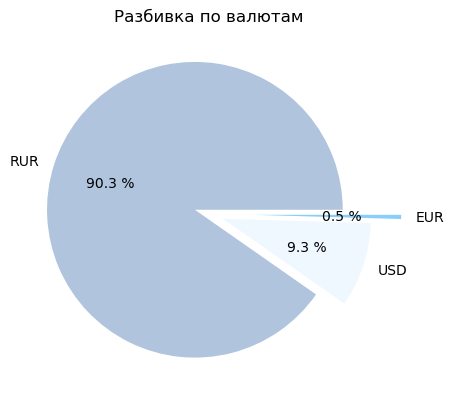

In [ ]:
plt.pie(vacs_clean['curr'].value_counts(), labels=['RUR', 'USD', 'EUR'], autopct='%.1f %%', explode=[0.1, 0.1, 0.3],
        colors=['lightsteelblue','aliceblue','lightskyblue'])
plt.title('Разбивка по валютам')
plt.show()

Мы видим что зарплаты выражены в разных валютах, а также приведены со значениями до и после уплаты налогов. Разнесём эту информацию по колонкам

In [ ]:
# Выделяем признак удержания налога, который мы будем исользовать как флаг для вычислений и чистим серию от этой информации.
vacs_clean['taxed'] = np.select([vacs_clean.salary.str.contains('на руки', na=False),
                                 vacs_clean.salary.str.contains('до вычета налогов', na=False)], [1, 0], np.nan)
vacs_clean.salary = vacs_clean.salary.str.replace("на руки", "")
vacs_clean.salary = vacs_clean.salary.str.replace("до вычета налогов", "")

In [ ]:
vacs_clean['position'] = vacs_clean.apply(
    lambda row: row['position'].replace(row['salary'], '').strip()
    if (pd.notnull(row['position']) and pd.notnull(row['salary'])) else row[
        'position'],
    axis=1)

In [ ]:
# vacs_clean.salary.dropna()

In [ ]:
for i in ['на руки', 'до вычета налогов']:
    vacs_clean.position = vacs_clean.position.str.replace(i, '')

In [ ]:
vacs_clean.salary = vacs_clean.salary.str.replace('rur', '').str.replace(
    '$', '').str.replace('EUR', ' ')

# Для позиций с указанным зарплатным коридором, извлекаем минимальные и максимальные значения

# vacs_clean[['min_sal', 'max_sal']]=(vacs_clean['salary'].str.split('–', expand=True) if
#                                     vacs_clean['salary'].str.contains('–') else [np.nan. np.nan])

In [ ]:

def process_salary(row):
    if pd.isna(row['salary']):
        return np.nan, np.nan  # Возвращаем NaN, если значение равно NaN

    if 'без' in row['salary']:
        # Извлечение максимальной зарплаты
        row['salary'] = row['salary'].split('без')[-2].lstrip()

    # Разделяем строку по '-'
    parts = row['salary'].split('–')
    # print(parts)
    # Если есть два части (разделитель найден)
    if len(parts) == 2:
        min_sal = parts[0].strip()  # первая часть
        max_sal = parts[1].strip()  # вторая часть
        return min_sal, max_sal

    # Если нет разделителя
    sal_str = parts[0].strip()
    if 'до' in sal_str:
        # Извлечение максимальной зарплаты
        max_sal = sal_str.split('до')[1].strip()
        return np.nan, max_sal

    if 'от' in sal_str:
        # Извлечение минимальной зарплаты
        min_sal = sal_str.split('от')[1].strip()
        return min_sal, np.nan

    # Если строка не соответствует ожиданиям, возвращаем NaN
    return np.nan, np.nan


# Применяем функцию и создаем новые колонки 'min_sal' и 'max_sal'
vacs_clean['min_sal'], vacs_clean['max_sal'] = zip(
    *vacs_clean.apply(process_salary, axis=1))

vacs_clean[['salary', 'min_sal', 'max_sal']].dropna(how='any').head(50)

,salary,min_sal,max_sal
8,130 000 – 160 000,130 000,160 000
12,10 000 – 20 000,10 000,20 000
14,5 000 – 8 000,5 000,8 000
16,120 000 – 180 000,120 000,180 000
20,5 000 – 8 000,5 000,8 000
30,3 500 – 4 000,3 500,4 000
58,300 000 – 400 000,300 000,400 000
62,200 000 – 300 000,200 000,300 000
80,200 000 – 220 000,200 000,220 000
86,250 000 – 350 000,250 000,350 000


In [ ]:
# Убираем пробелы отражающие разряды чисел.
vacs_clean.min_sal = pd.to_numeric(vacs_clean.min_sal.str.replace(' ', ''))
vacs_clean.max_sal = pd.to_numeric(vacs_clean.max_sal.str.replace(' ', ''))

In [ ]:
num_sal_rec=vacs_clean[['min_sal', 'max_sal']].dropna(how='all').shape[0]

In [ ]:
Markdown(f"Итак количество записей содержащих зарплатные предложения : {num_sal_rec}, что составляет {round(100*num_sal_rec/vacs_clean.shape[0], 1)} % от общего количества записей. Проверим все ли значения являются валидными ".format(len(df)))

Итак количество записей содержащих зарплатные предложения : 100, что составляет 11.3 % от общего количества записей. Проверим все ли значения являются валидными 

In [ ]:
vacs_clean[['min_sal', 'max_sal']].describe().round(0).T

,count,mean,std,min,25%,50%,75%,max
min_sal,74.0,156945.0,109322.0,2500.0,80000.0,165000.0,247500.0,400000.0
max_sal,72.0,228455.0,153619.0,3000.0,125000.0,235000.0,327500.0,550000.0


Пересчитаем все имеющиеся валютные значения в рубли по текущему курсу ЦБ РФ

In [ ]:
vacs_clean['min_sal_rur'] = vacs_clean['min_sal'] * vacs_clean['curr']
vacs_clean['max_sal_rur'] = vacs_clean['max_sal'] * vacs_clean['curr']

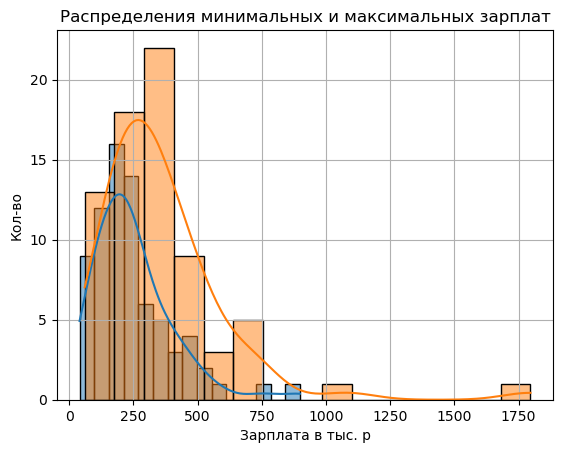

In [ ]:
sns.histplot(vacs_clean['min_sal_rur']/1000, kde=True, bins=15)
sns.histplot(vacs_clean['max_sal_rur']/1000, kde=True, bins=15)
plt.xlabel('Зарплата в тыс. р')
plt.ylabel('Кол-во')
plt.title('Распределения минимальных и максимальных зарплат')
plt.grid()
plt.show()

Приведение к сумме после уплаты налогов

In [ ]:
# Годовые оклады, минимальный и максимальный
vacs_clean['min_annual_sal'] = vacs_clean['min_sal_rur'] * 12
vacs_clean['max_annual_sal'] = vacs_clean['max_sal_rur'] * 12

# Минимальный годовой оклад превышающий 5 млн. рублей и облагаемый по ставке 15%
ann_15_min = vacs_clean[vacs_clean.taxed == 0][vacs_clean.loc[
    vacs_clean.taxed == 0, 'min_annual_sal'] >= 5E6]
display(ann_15_min)

# Максимальный годовой оклад превышающий 5 млн. рублей и облагаемый по ставке 15%
ann_15_max = vacs_clean[vacs_clean.taxed == 0][vacs_clean.loc[
    vacs_clean.taxed == 0, 'max_annual_sal'] >= 5E6]
display(ann_15_max)

# Индексы позиций с высоким годовым доходом
ind_ann_15_min, ind_ann_15_max = ann_15_min.index, ann_15_max.index

# Высокий годовой доход (минимальным и максимальные значения) после уплаты налога 15%
vacs_clean.loc[ind_ann_15_min, 'min_sal_rur'] = (
    vacs_clean.loc[ind_ann_15_min, 'min_sal_rur'] * 0.85).round(0)
display(vacs_clean.loc[ind_ann_15_min, 'min_sal_rur'])
#
vacs_clean.loc[ind_ann_15_max, 'max_sal_rur'] = (
    vacs_clean.loc[ind_ann_15_max, 'max_sal_rur'] * 0.85).round(0)
display(vacs_clean.loc[ind_ann_15_max, 'max_sal_rur'])

,position,company,experience,salary,metro,curr,taxed,min_sal,max_sal,min_sal_rur,max_sal_rur,min_annual_sal,max_annual_sal
14,lead frontend developer,podscribe,3-6,5 000 – 8 000,,89.8225,0.0,5000.0,8000.0,449112.50,7.185800e+05,5389350.0,8.622960e+06
510,senior engineering manager,emfi technologies limited,> 6,6 000 – 8 000,,89.8225,0.0,6000.0,8000.0,538935.00,7.185800e+05,6467220.0,8.622960e+06
652,c++ developer with relocation to berlin 7 500 – 10 834 € без,а think-cell,0-1,7 500 – 10 834,,99.7156,0.0,7500.0,10834.0,747867.00,1.080319e+06,8974404.0,1.296383e+07
854,senior/lead go developer (blockchain),emfi technologies limited,> 6,6 500 – 8 000,,89.8225,0.0,6500.0,8000.0,583846.25,7.185800e+05,7006155.0,8.622960e+06
866,strong senior python engineer 5 000 – 7 000 €,ооо betby,> 6,5 000 – 7 000,,99.7156,0.0,5000.0,7000.0,498578.00,6.980092e+05,5982936.0,8.376110e+06
1176,"software engineer - nextflow & python, new zealand",гк визави консалт,3-6,5 000 – 6 500,,89.8225,0.0,5000.0,6500.0,449112.50,5.838462e+05,5389350.0,7.006155e+06


,position,company,experience,salary,metro,curr,taxed,min_sal,max_sal,min_sal_rur,max_sal_rur,min_annual_sal,max_annual_sal
14,lead frontend developer,podscribe,3-6,5 000 – 8 000,,89.8225,0.0,5000.0,8000.0,449112.50,7.185800e+05,5389350.0,8.622960e+06
54,data engineer,rubbles,3-6,до 500 000,,1.0000,0.0,NaN,500000.0,NaN,5.000000e+05,NaN,6.000000e+06
270,full-stack team lead,getmatch,> 6,до 500 000,,1.0000,0.0,NaN,500000.0,NaN,5.000000e+05,NaN,6.000000e+06
510,senior engineering manager,emfi technologies limited,> 6,6 000 – 8 000,,89.8225,0.0,6000.0,8000.0,538935.00,7.185800e+05,6467220.0,8.622960e+06
580,data engineer lead / dwh architect,lion recruitment,3-6,350 000 – 450 000,,1.0000,0.0,350000.0,450000.0,350000.00,4.500000e+05,4200000.0,5.400000e+06
652,c++ developer with relocation to berlin 7 500 – 10 834 € без,а think-cell,0-1,7 500 – 10 834,,99.7156,0.0,7500.0,10834.0,747867.00,1.080319e+06,8974404.0,1.296383e+07
854,senior/lead go developer (blockchain),emfi technologies limited,> 6,6 500 – 8 000,,89.8225,0.0,6500.0,8000.0,583846.25,7.185800e+05,7006155.0,8.622960e+06
866,strong senior python engineer 5 000 – 7 000 €,ооо betby,> 6,5 000 – 7 000,,99.7156,0.0,5000.0,7000.0,498578.00,6.980092e+05,5982936.0,8.376110e+06
1176,"software engineer - nextflow & python, new zealand",гк визави консалт,3-6,5 000 – 6 500,,89.8225,0.0,5000.0,6500.0,449112.50,5.838462e+05,5389350.0,7.006155e+06
1226,lead data scientist,rubbles,> 6,до 550 000,,1.0000,0.0,NaN,550000.0,NaN,5.500000e+05,NaN,6.600000e+06


14      381746.0
510     458095.0
652     635687.0
854     496269.0
866     423791.0
1176    381746.0
Name: min_sal_rur, dtype: float64

14      610793.0
54      425000.0
270     425000.0
510     610793.0
580     382500.0
652     918271.0
854     610793.0
866     593308.0
1176    496269.0
1226    467500.0
Name: max_sal_rur, dtype: float64

Теперь сделаем то же самое с зарплатами до налогооблажения с годовым доходом до 5 млн рублей, облагаемым налогом 13%

In [ ]:
ann_13_min = vacs_clean[vacs_clean.taxed == 0][vacs_clean.loc[
    vacs_clean.taxed == 0, 'min_annual_sal'] < 5E6]
display(ann_13_min)

ann_13_max = vacs_clean[vacs_clean.taxed == 0][vacs_clean.loc[
    vacs_clean.taxed == 0, 'max_annual_sal'] < 5E6]
display(ann_13_max)

ind_ann_13_min, ind_ann_13_max = ann_13_min.index, ann_13_max.index

vacs_clean.loc[ind_ann_13_min, 'min_sal_rur'] = (
    vacs_clean.loc[ind_ann_13_min, 'min_sal_rur'] * 0.87).round(0)
display(vacs_clean.loc[ind_ann_13_min, 'min_sal_rur'])

vacs_clean.loc[ind_ann_13_max, 'max_sal_rur'] = (
    vacs_clean.loc[ind_ann_13_max, 'max_sal_rur'] * 0.87).round(0)
display(vacs_clean.loc[ind_ann_13_max, 'max_sal_rur'])

,position,company,experience,salary,metro,curr,taxed,min_sal,max_sal,min_sal_rur,max_sal_rur,min_annual_sal,max_annual_sal
8,backend разработчик (java),ооо снэп айти,1-3,130 000 – 160 000,,1.0000,0.0,130000.0,160000.0,130000.00,160000.0,1560000.0,1920000.0
30,старший ios разработчик,voicepop,3-6,3 500 – 4 000,,89.8225,0.0,3500.0,4000.0,314378.75,359290.0,3772545.0,4311480.0
58,дата инженер (удаленно),лэтуаль диджитал,3-6,300 000 – 400 000,нахимовский проспект,1.0000,0.0,300000.0,400000.0,300000.00,400000.0,3600000.0,4800000.0
62,data scientist (скоринг),поток.диджитал,1-3,200 000 – 300 000,,1.0000,0.0,200000.0,300000.0,200000.00,300000.0,2400000.0,3600000.0
80,тестировщик продуктов data,ип лукавская ирина анатольевна,3-6,200 000 – 220 000,,1.0000,0.0,200000.0,220000.0,200000.00,220000.0,2400000.0,2640000.0
160,data/product analyst,repay,3-6,от 2 500,,89.8225,0.0,2500.0,NaN,224556.25,NaN,2694675.0,NaN
202,"data engineer москва ... 18 инженер-аналитик (data scientist (python, sql, ml, c++)",ао научно-производственное объединение дальней радиолокации имени академика а.л. минца,1-3,от 74 250,динамо,1.0000,0.0,74250.0,NaN,74250.00,NaN,891000.0,NaN
326,data engineer senior,volna.tech,3-6,200 000 – 400 000,,1.0000,0.0,200000.0,400000.0,200000.00,400000.0,2400000.0,4800000.0
344,data engineer/дата инженер (ученик) без,а aston,0-1,100 000 – 110 000,,1.0000,0.0,100000.0,110000.0,100000.00,110000.0,1200000.0,1320000.0
482,senior data engineer,repay,> 6,от 4 000,,89.8225,0.0,4000.0,NaN,359290.00,NaN,4311480.0,NaN


,position,company,experience,salary,metro,curr,taxed,min_sal,max_sal,min_sal_rur,max_sal_rur,min_annual_sal,max_annual_sal
8,backend разработчик (java),ооо снэп айти,1-3,130 000 – 160 000,,1.0000,0.0,130000.0,160000.0,130000.00,160000.0,1560000.0,1920000.0
30,старший ios разработчик,voicepop,3-6,3 500 – 4 000,,89.8225,0.0,3500.0,4000.0,314378.75,359290.0,3772545.0,4311480.0
36,аналитик (офис),европейский медицинский центр,1-3,до 180 000,проспект мира,1.0000,0.0,NaN,180000.0,NaN,180000.0,NaN,2160000.0
58,дата инженер (удаленно),лэтуаль диджитал,3-6,300 000 – 400 000,нахимовский проспект,1.0000,0.0,300000.0,400000.0,300000.00,400000.0,3600000.0,4800000.0
62,data scientist (скоринг),поток.диджитал,1-3,200 000 – 300 000,,1.0000,0.0,200000.0,300000.0,200000.00,300000.0,2400000.0,3600000.0
80,тестировщик продуктов data,ип лукавская ирина анатольевна,3-6,200 000 – 220 000,,1.0000,0.0,200000.0,220000.0,200000.00,220000.0,2400000.0,2640000.0
92,разработчик баз данных,ооо атлас,3-6,до 300 000,,1.0000,0.0,NaN,300000.0,NaN,300000.0,NaN,3600000.0
146,python-разработчик в отдел bi (офис) без,"а ооо бристоль, сеть магазинов",0-1,до 218 400,,1.0000,0.0,NaN,218400.0,NaN,218400.0,NaN,2620800.0
310,crewing manager assistant,airecruitment,1-3,до 170 000,,1.0000,0.0,NaN,170000.0,NaN,170000.0,NaN,2040000.0
326,data engineer senior,volna.tech,3-6,200 000 – 400 000,,1.0000,0.0,200000.0,400000.0,200000.00,400000.0,2400000.0,4800000.0


8       113100.0
30      273510.0
58      261000.0
62      174000.0
80      174000.0
160     195364.0
202      64598.0
326     174000.0
344      87000.0
482     312582.0
580     304500.0
582     147900.0
600     217500.0
922     149640.0
1010    130500.0
1050    191400.0
1078    217500.0
1146    208800.0
1354     87000.0
1382     87000.0
1392     80040.0
1404    261000.0
1672    174000.0
1736    304500.0
Name: min_sal_rur, dtype: float64

8       139200.0
30      312582.0
36      156600.0
58      348000.0
62      261000.0
80      191400.0
92      261000.0
146     190008.0
310     147900.0
326     348000.0
342     217500.0
344      95700.0
452     147900.0
462     217500.0
582     174000.0
600     261000.0
922     149640.0
1010    243600.0
1050    217500.0
1062    348000.0
1382     95700.0
1392    117450.0
1672    182700.0
Name: max_sal_rur, dtype: float64

Смотрим как выглядят наши преобразованные данные

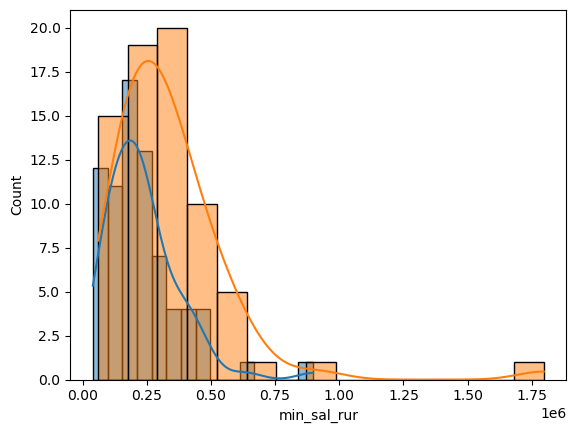

In [ ]:
sns.histplot(vacs_clean['min_sal_rur'], kde=True, bins=15)
sns.histplot(vacs_clean['max_sal_rur'], kde=True, bins=15)
plt.show()

In [ ]:
desc_sal=vacs_clean[['min_sal_rur', 'max_sal_rur']].describe().round(0).T
display((desc_sal/1000).round(0))

,count,mean,std,min,25%,50%,75%,max
min_sal_rur,0.0,235.0,143.0,40.0,140.0,200.0,297.0,898.0
max_sal_rur,0.0,336.0,239.0,60.0,182.0,300.0,409.0,1796.0


In [ ]:
a=Markdown(f'  Медианное значение зарплат по позициям выдаваемых по поисковому запросу: "Data Engineer" составляет:')
b=Markdown(f'* Для нижней границы зарплатного коридора {desc_sal.loc["min_sal_rur", "50%"]/1000} тыс. р')
c=Markdown(f'* Для верхней границы зарплатного коридора {desc_sal.loc["max_sal_rur", "50%"]/1000} тыс. р')
display(a, b, c)

  Медианное значение зарплат по позициям выдаваемых по поисковому запросу: "Data Engineer" составляет:

* Для нижней границы зарплатного коридора 200.0 тыс. р

* Для верхней границы зарплатного коридора 300.0 тыс. р

### Первичный анализ данных

In [ ]:
exper_dist=vacs_clean.experience.value_counts(normalize=True).round(3)*100
exper_dist

experience
3-6    53.5
1-3    35.4
> 6     8.5
0-1     2.6
Name: proportion, dtype: float64

In [ ]:
Markdown(f' Итак почти {sum(exper_dist[:-1])} % вакансий, преполагают опыт работы более года' )

 Итак почти 97.4 % вакансий, преполагают опыт работы более года

Посмотрим насколько сильно меняется уровень зарплаты в зависимости от стажа (уникальное значение в 180000 мы рассматривать не будем)

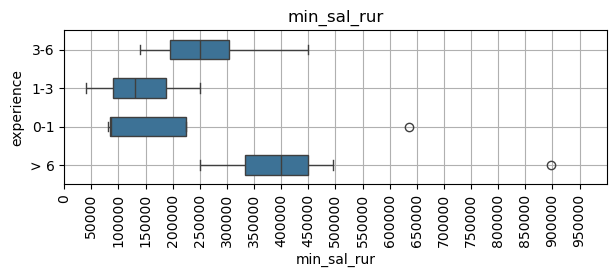

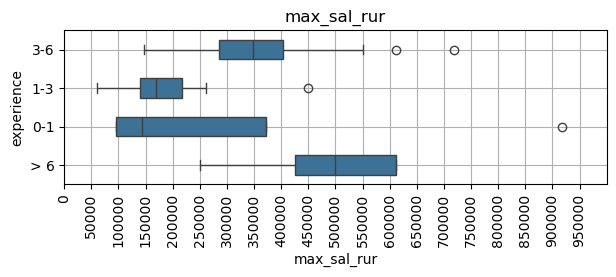

In [ ]:

for sal in ['min_sal_rur', 'max_sal_rur']:
    plt.figure(figsize=(7,2))

    plt.xlim([0, 1000000])
    sns.boxplot(data=vacs_clean, x=sal, y='experience',
               orient='h', saturation=0.6, width=0.5,
              fill=True, legend='full').grid()

    plt.title(sal)
    plt.xticks(np.arange(0, 1000000, step=50000), rotation=90)
    plt.show()
# sns.histplot(data=vacs_clean, x='max_sal', y='experience')


In [ ]:
vacs_clean.groupby('experience')[['min_sal_rur',
                                  'max_sal_rur']].agg(['min', 'max', 'median'
                                                       ]).astype(int).stack()

min_sal_rur  max_sal_rur
experience                                 
0-1        min           80000        95700
           max          635687       918271
           median        87000       142854
1-3        min           40000        60000
           max          250000       450000
           median       130000       170000
3-6        min          140000       147900
           max          449112       718580
           median       250000       348000
> 6        min          250000       250000
           max          898225      1796450
           median       400000       498578

In [ ]:
Почсмотрим, зависит

In [ ]:
entity_form_sal={}
for cf in ["ип", "ооо", "ао"]:
    entity_form_sal[cf]=vacs_clean[vacs_clean.company.str.contains(cf)][[
        'min_sal_rur', 'max_sal_rur']].agg(
        ['min', 'mean', 'median', 'max', 'count']).T

display(vacs_clean[vacs_clean.company.str.contains("ип|ооо|ао")== False][[
        'min_sal_rur', 'max_sal_rur']].agg(
        ['min', 'mean', 'median', 'max', 'count']).round(0))
pd.concat(entity_form_sal).round(0)
# display(cf, )


,min_sal_rur,max_sal_rur
min,80000.0,95700.0
mean,266230.0,376093.0
median,250000.0,320000.0
max,898225.0,1796450.0
count,45.0,47.0


min      mean    median       max  count
ип  min_sal_rur   80000.0  127000.0  127000.0  174000.0    2.0
    max_sal_rur  130000.0  160700.0  160700.0  191400.0    2.0
ооо min_sal_rur   40000.0  194012.0  200000.0  423791.0   24.0
    max_sal_rur   60000.0  277934.0  246800.0  593308.0   20.0
ао  min_sal_rur   64598.0  154746.0  149640.0  250000.0    3.0
    max_sal_rur  147900.0  215847.0  149640.0  350000.0    3.0

Как мы видим, данных по форме собственности для зарплат очень мало. Конечно мы можем вручную найти отсутствующие формы собственности в интернете и обогатить наши данные, но в этом исследовании мы ограничимся теми данными что мы имеем. Хотя данные и непредставительны ввиду крайне малого количества наблюдений, можно предположить что они тем не менее отражают различие в оплате труда. Если это так,то:

1) Для ООО стартовые зарплаты ниже чем для ИП и акционерных обществ

2) У них также самые высокие медианные зарплаты

Удаляем данныее по форме собственности

In [ ]:
for cf in ["ип", "ооо", "ао"]:
    vacs_clean.company = vacs_clean.company.str.replace(cf, '').str.strip()


теперь посмотрим, какиекомпании предлагают самые высокие и самые низкие должностные оклады (медианные значения).

In [ ]:
sal_by_comp=(vacs_clean.groupby('company')[['min_sal_rur', 'max_sal_rur']].median()/1000
).round(0).dropna(how='all')

sal_by_comp.sort_values('min_sal_rur').min_sal_rur.head(10)

company
дельта джи                                                                             40.0
научно-производственное объединение дальней радиолокации имени академика а.л. минца    65.0
северный ветер                                                                         80.0
шлыков станислав игоревич                                                              80.0
а oxygen data centers & clouds                                                         80.0
а  aston                                                                               87.0
специальные технологии контроля                                                        87.0
метахим                                                                                90.0
форм                                                                                   90.0
спецдорпроект                                                                          90.0
Name: min_sal_rur, dtype: float64

In [ ]:
sal_by_comp.sort_values('max_sal_rur', ascending=False).max_sal_rur.head(10)

company
ри в квадрате                1796.0
а think-cell                  918.0
mt lab                        719.0
podscribe                     611.0
emfi technologies limited     611.0
betby                         546.0
точка                         525.0
диджитал лайн                 499.0
гк визави консалт             496.0
вовнянко олеся викторовна     494.0
Name: max_sal_rur, dtype: float64

In [ ]:
Markdown(f'Как мы видим, минимальные оклады предлагаются команией \
__{sal_by_comp.min_sal_rur.idxmin()}__, a самые значительные  \
         - компанией __{sal_by_comp.max_sal_rur.idxmax()}__ . Основные игроки рынка в списке \
отсутствуют, зато среди компаний предлагающих самые высокие оклады, \
встречаются специализированные рекрутинговые агентства, которые \
по всей видимости изучают зарплатные ожидания специалистов высочайшей \
квалификации, либо осуществляют их поиск для крупных клиентов не афиширующих\
в своих объявлениях о вакансиях зарплатные предложения для таких сотрудников ')

Как мы видим, минимальные оклады предлагаются команией __дельта джи__, a самые значительные           - компанией __ри в квадрате__ . Основные игроки рынка в списке отсутствуют, зато среди компаний предлагающих самые высокие оклады, встречаются специализированные рекрутинговые агентства, которые по всей видимости изучают зарплатные ожидания специалистов высочайшей квалификации, либо осуществляют их поиск для крупных клиентов не афиширующихв своих объявлениях о вакансиях зарплатные предложения для таких сотрудников 

In [ ]:
# comp_count_min = vacs_clean.astype(int, errors='ignore').groupby(
#     'company').min_sal_rur.count().sort_values()
# comp_count_max = vacs_clean.astype(int, errors='ignore').groupby(
#     'company').max_sal_rur.count().sort_values()
# comp_count_max[comp_count_max > 1]
# # [['min_sal_rur', 'max_sal_rur']].agg(['min', 'median', 'max', 'count']).dropna().unstack().unstack()

company
а  aston                     2
ооо betby                    2
кофемания                    2
ооо всеинструменты.ру        2
excdev                       2
rubbles                      2
emfi technologies limited    2
точка                        2
монета                       2
Name: max_sal_rur, dtype: int64

In [ ]:
sal_by_comp.sort_values('max_sal_rur', ascending=False).head(10)

,min_sal_rur,max_sal_rur
company,,
ри в квадрате,898.0,1796.0
а think-cell,636.0,918.0
mt lab,449.0,719.0
podscribe,382.0,611.0
emfi technologies limited,477.0,611.0
betby,411.0,546.0
точка,NaN,525.0
диджитал лайн,NaN,499.0
гк визави консалт,382.0,496.0


### Изучение описания вакансий

Посмотрим теперь какие слова чаще всего встречаются названии компании объявившей о вакансии

In [ ]:
cnt = Counter(str(vacs_clean.company.values).split(' '))

df = pd.DataFrame(cnt, index=['Freq']).T
# df=df[df.Freq>1]
df = df.reset_index(names='Word').sort_values('Freq', ascending=False)
df.Word = df.Word.str.extract(r'(\w+)')

df.groupby('Word').Freq.sum().sort_values(ascending=False)

Word
сбер         91
digital      76
для          67
экспертов    67
data         59
             ..
авторусь      1
автомакон     1
абсолют       1
а2            1
глобус        1
Name: Freq, Length: 654, dtype: int64

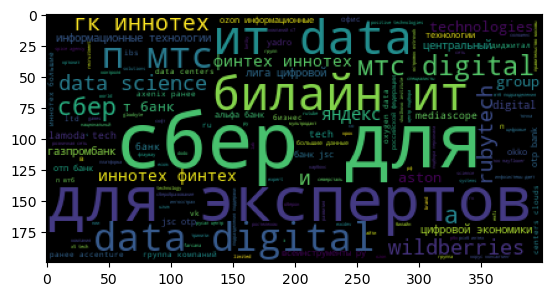

In [ ]:
plt.imshow(WordCloud().generate(' '.join(vacs_clean.company)))

Как Мы видим, лидирует Сбер.

Теперь посмотрим какие слова  у нас встречаются в названии позиции

In [ ]:
cnt = Counter(str(vacs_clean.position.values).split(' '))


df = pd.DataFrame(cnt, index=['Freq']).T
df = df.reset_index(names='Word').sort_values('Freq', ascending=False)
df.Word = df.Word.str.extract(r'(\w+)')

df.groupby('Word').Freq.sum().sort_values(ascending=False).head(20)

Word
engineer        589
data            471
senior          147
analyst         103
lead             85
scientist        72
ml               58
middle           53
devops           44
qa               35
developer        34
architect        24
данных           21
system           19
manager          18
automation       16
junior           15
product          13
big              13
руководитель     12
Name: Freq, dtype: int64

Итак мы видим направления и уровень квалификации

In [ ]:
# str(vacs_clean.position.values).split(' ')

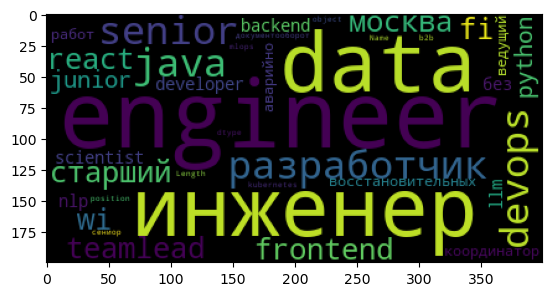

In [ ]:
plt.imshow(WordCloud().generate(str(vacs_clean.position.str.split(' '))))


In [ ]:
' * '.join(pos_words.unique())

'senior * engineer * teamlead * data * frontend * react * junior * developer * backend * group * engineering * manager * major * real * estate * infrastructure * nairobi * kenya * lead * analyst * ml * scientist * digital * marketing * haier * kitchen * lab * head * of * analytics * machine * learning * prompt * ios * intern * офис * маркетинговый * исследователь * сервис * путешествий * technical * support * vietnam * отелей * сервиса * middle * мтс * analystа * группа * внутренних * сервисов * ozon * банк * диджитал * vue * js * удаленно * скоринг * качеству * данных * тв * big * тестировщик * продуктов * processing * elt * software * баз * эксплуатации * цод * м * текстильщики * nlp * llm * удаленка * продукт * golden * record * spark * qa * sberbilling * автоматизации * flask * regional * sales * operations * мобильное * it * pricing * devops * arenadata * db * bi * отдел * system * architect * mena * программист * асутп * product * управление * анализа * информационной * опасности

In [ ]:
# plt.imshow(words.generate(" ".join(vacs_clean.position.values).split()))
# plt.show()
# plt.imshow(words.generate(str(vacs_clean.company.values)))
# plt.show()
# plt.imshow(words.generate(str(vacs_clean.metro.values)))
# plt.show()

In [ ]:
pos_desc = ''.join(vacs_clean.position)

In [ ]:
# vacs_clean['position_']=vacs_clean['position'].copy() # для контроля обработки данных, сохраняем исходную сирию описаний позиции
# vacs_clean['position']=vacs_clean['position_'].copy()

vacs_clean['position'] = vacs_clean['position'].apply(
    lambda x: re.sub(r'\s{2,}', ' ', x))  # удаляем лишние пробелы

Создаём стоп-лист с предлогами и часто упоминающейся в вакансиях Москвой, а также словарь для унификации текста вакансии переводом на английский слов входящих в состав названия вакансии

In [ ]:
stops = [' по ', ' к ', ' с ', ' a ', ' и ', ' на ', ' до ', ' в ', 'москва']

title_dict = OrderedDict()

title_dict = {'инженер данных': 'data engineer',
              'дата инженер': 'data engineer',
              'инженер': 'engineer',
              'ведущий': 'lead',
              'старший': 'senior',
              'сениор': 'senior',
              'продуктовый': 'product',
              'ml инженер': 'ml engineer',
              'machine learning engineer': 'ml engineer',
              'без': '',
              'системный аналитик': 'system analyst',
              'аналитик данных': 'data analyst',
              'москва data engineer': '',
              'dwh': '',
              'рекламная платформа': '',
              'clickhouse': '',
              'greenplum': '',
              'поиск': '',
              'аналитик': 'analyst',
              'hadoop': '',
              'etl': '',
              'стажер': 'intern',
              'trainee': 'intern',
              'стажёр': 'intern',
              'разработчик': '',
              'java': '',
              ' c ': ' ',
              'engineer по автоматизации тестирования': 'qa automation engineer',
              'qa engineer тестировщик': 'qa engineer',
              'трайб data': '',
              'wi fi': '',
              'python': '',
              # 'дата':'data',
              'дата': '',
              'команда развития платформы': '',
              'рекомендательные системы': 'recommendation systems',
              'сервисный': 'service',
              'продажи': 'sales',
              'data engineer senior': 'senior data engineer',
              'финтех': '',
              'office': '',
              'архитектор': 'architect',
              'процесс': 'process',
              'команду': '',
              'продакт': 'product',
              'engineer автоматизации тестирования': 'qa automation engineer'
              }

In [ ]:
# for stop in string.punctuation:
#         print(stop)

In [ ]:
def title_to_en(x):
    for pat, repl in title_dict.items():
        x = x.replace(pat, repl)
    return x


def punct_cleaner(x):
    for pun in string.punctuation:
        x = x.replace(pun, ' ')
    return x


def sw_cleaner(x):
    for stop in stops:
        x = x.replace(stop, ' ')
        # x=x.apply(lambda x: re.sub(r'\s{2,}', ' ', x))
    return x

In [ ]:
def duplicate_phrases_remover(text):
    # Удаляем последовательные повторения двухсловных фраз
    if not text:
        return None
    return re.sub(r'(\b\w+\s+\w+\b)(?=.*\1)', '', text).strip()


def digits_remover(row):
    try:
        denum = " ".join(x for x in row.split() if x.isalpha())
        return denum
    except:
        return None

In [ ]:
vacs_clean['position'] = vacs_clean['position'].apply(
    punct_cleaner).apply(sw_cleaner).apply(title_to_en)
vacs_clean['position'] = vacs_clean['position'].str.strip().apply(
    lambda x: re.sub(r'\s{2,}', ' ', x))

vacs_clean['position'] = vacs_clean['position'].apply(
    duplicate_phrases_remover)

In [ ]:
vacs_clean['position'] = vacs_clean['position'].str.replace(
    r'\d+', '', regex=True).str.strip()
vacs_clean['position'].value_counts().head(60)

position
data engineer                                                             131
senior data engineer                                                       26
devops engineer                                                            13
ml engineer                                                                10
data analyst                                                               10
lead data engineer                                                          6
junior data engineer                                                        5
middle data engineer                                                        5
qa automation engineer                                                      5
data scientist                                                              5
senior data scientist                                                       4
Позиция не указана                                                          4
qa engineer                                            

In [ ]:
vacs_clean['position'] = vacs_clean['position'].fillna(
    'Позиция не указана').apply(sw_cleaner)

In [ ]:
vacs_clean['position_title'] = vacs_clean['position'].str.split(
    ' ').apply(lambda x: ' '.join(x[:4]))

In [ ]:
vacs_clean['position_title'].value_counts().head(60)

position_title
data engineer                              131
senior data engineer                        23
devops engineer                             13
ml engineer                                 10
data analyst                                10
data scientist ml engineer                   7
lead data engineer                           6
middle data engineer                         5
qa automation engineer                       5
data scientist                               5
junior data engineer                         5
data engineer data analyst                   4
senior data scientist                        4
Позиция не указана                           4
middle senior data engineer                  4
senior ml engineer                           3
data engineer middle                         3
mlops engineer                               3
developer                                    3
qa engineer                                  3
senior engineer                              

In [ ]:
main_roles = ['data engineer',
              'devops engineer',
              'ml engineer',
              'data analyst',
              'data scientist',
              'qa automation engineer',
              'system analyst',
              'mlops engineer',
              'developer',
              'architect mlops',
              'qa engineer',
              'computer vision engineer'
              ]

grades = ['lead', 'senior', 'middle', 'junior', 'intern']

В завершении для каждой позиции найдём медианные значения окладов, а также распределение количества записей по стажу для каждой из позиций.

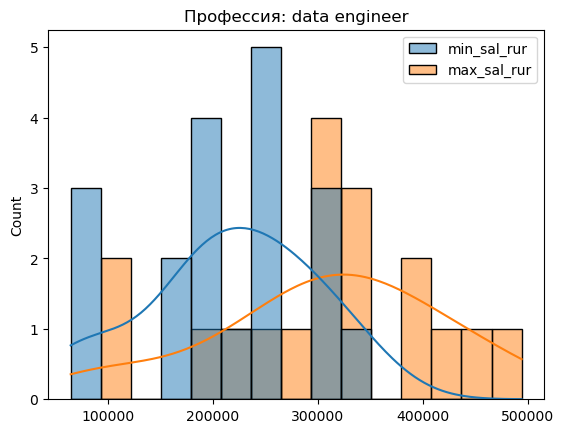

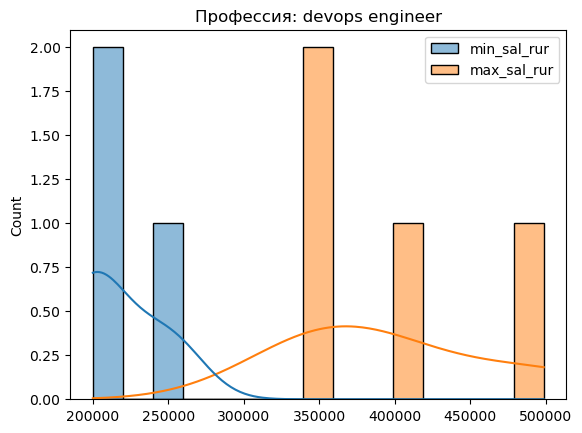

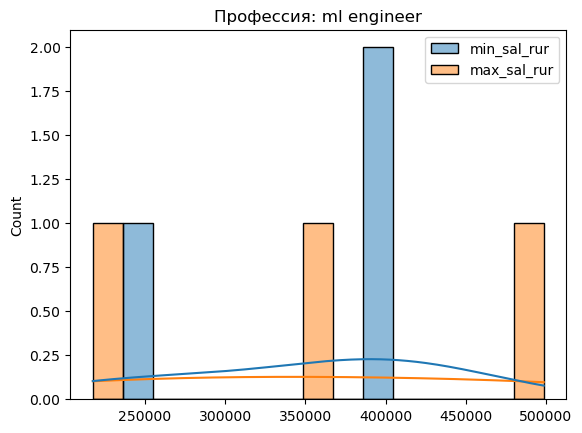

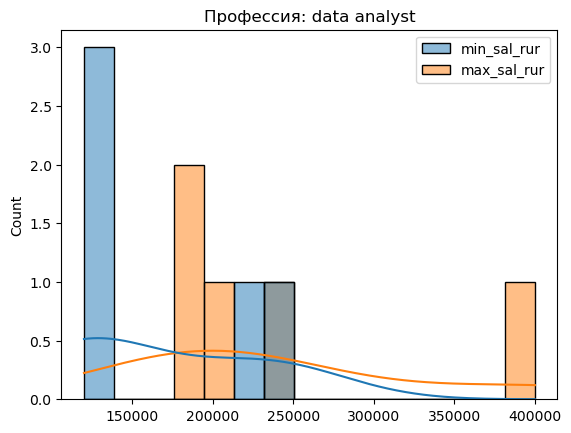

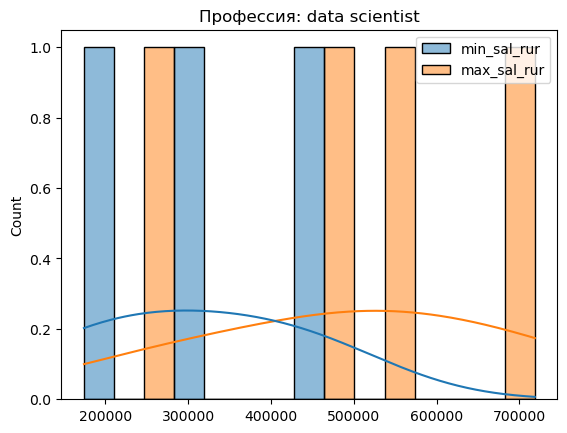

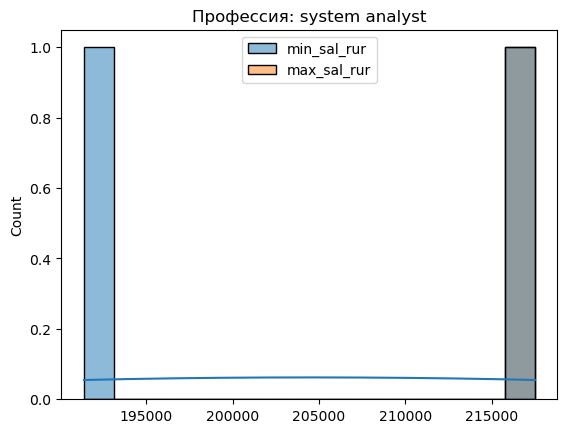

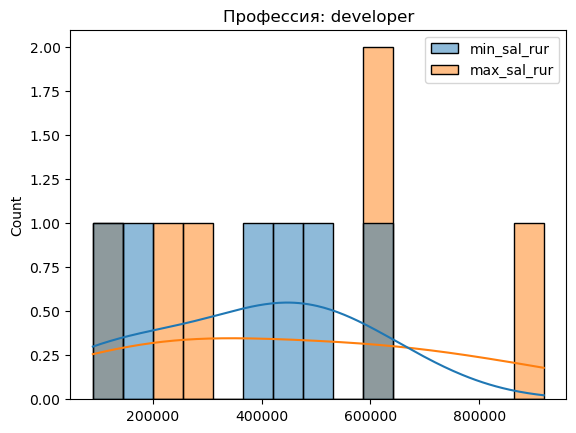

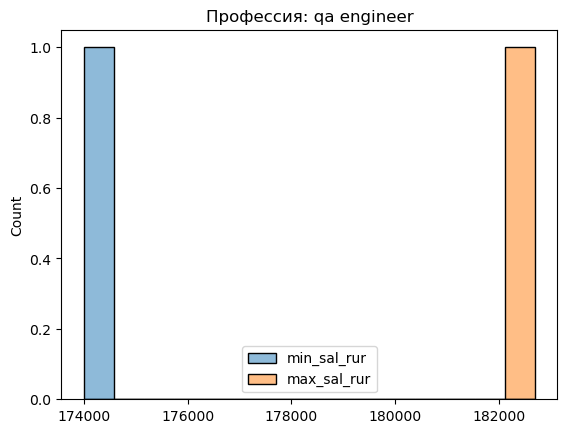

,%,"median salary min, krur","median salary max, krur",3-6,1-3,> 6,0-1
data engineer,NaN,208.8,310.0,50.3,41.9,4.5,3.2
devops engineer,NaN,200.0,375.0,71.4,20.0,8.6,NaN
ml engineer,NaN,398.9,350.0,65.0,25.0,7.5,2.5
data analyst,NaN,130.5,200.0,48.6,48.6,2.7,NaN
data scientist,NaN,304.5,508.8,50.8,44.4,4.8,NaN
qa automation engineer,NaN,NaN,NaN,92.3,7.7,NaN,NaN
system analyst,NaN,204.4,217.5,66.7,33.3,NaN,NaN
mlops engineer,NaN,NaN,NaN,80.0,20.0,NaN,NaN
developer,NaN,415.4,455.4,54.5,27.3,12.1,6.1
architect mlops,NaN,NaN,NaN,100.0,NaN,NaN,NaN


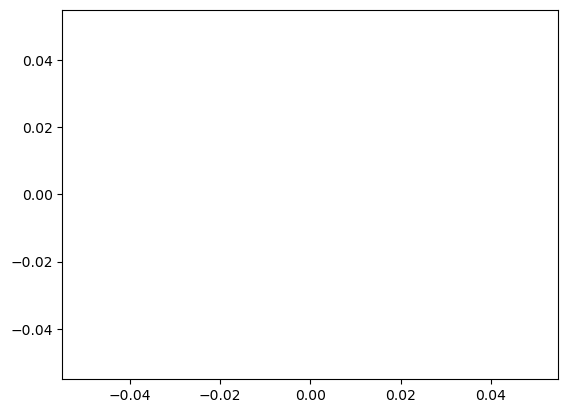

In [ ]:
roles_disribution = dict()
median_sal_role_min = dict()
median_sal_role_max = dict()
expirience_distribution = dict()
for role in main_roles:
    role_temp = vacs_clean.position_title.str.contains(role)
    # roles_disribution[role]=role_temp.value_counts(normalize=True).loc[True].round(2)*100
    median_sal_role_min[role] = vacs_clean[role_temp].min_sal_rur.median()/1000
    median_sal_role_max[role] = vacs_clean[role_temp].max_sal_rur.median()/1000
    expirience_distribution[role] = vacs_clean[role_temp].experience.value_counts(
        normalize=True).to_dict()
    try:
        hists = sns.histplot(vacs_clean.loc[role_temp,
                                            ['min_sal_rur', 'max_sal_rur']],
                             kde=True, bins=15).set_title(f'Профессия: {role}')
        plt.show()
    except:
        pass
role_sal = pd.DataFrame([roles_disribution,
                         median_sal_role_min,
                        median_sal_role_max],
                        index=['%', 'median salary min, krur', 'median salary max, krur']).T.round(1)

pd.concat([role_sal, pd.DataFrame(
    expirience_distribution).T.round(3)*100], axis=1)

Итак,

1) для нижнего уровня зарплат, максимаьное медианное значение наблюдается для разработчиков, а самое низкое для позиции data analyst
2) для верхнего уровня зарплат, максимаьное медианное значение наблюдается для data scientist а самое низкое для позиции qa engineer
3) Сотруднииков без опыта, работодатели готовы рассматривать на позиции developer, ml engineer, data engineer
4) Подавляющее большинство вакансий требуют опыта от одного года до шести лет. Особенно это касается тестировщиков, специалистов в ML/MLOPS
5) Самый высокий спрос на сотрудников с опытом работы более 6 лет, наблюдается для профессии разработчкик
6) Чаще всего, требования ко стажу 1-3 года, встречаются у специалистов по компьютерному зрению.

Аналогично, сведём данные о зарплатах и для распределению по стажам и для различных уровней квалификации

In [ ]:
grades_disribution = dict()
median_sal_grade_min = dict()
median_sal_grade_max = dict()
expirience_distribution = dict()

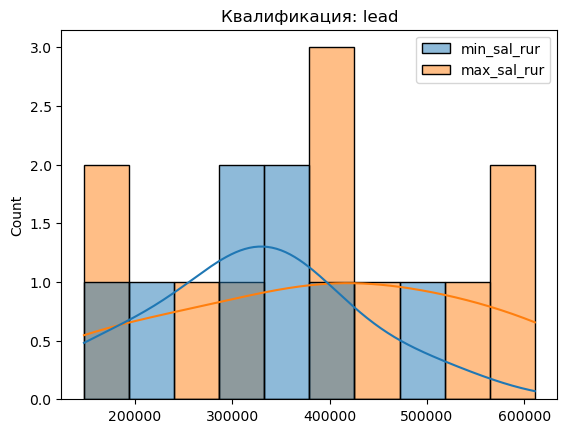

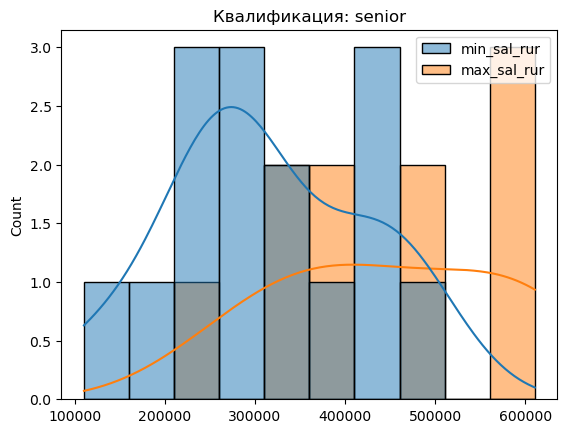

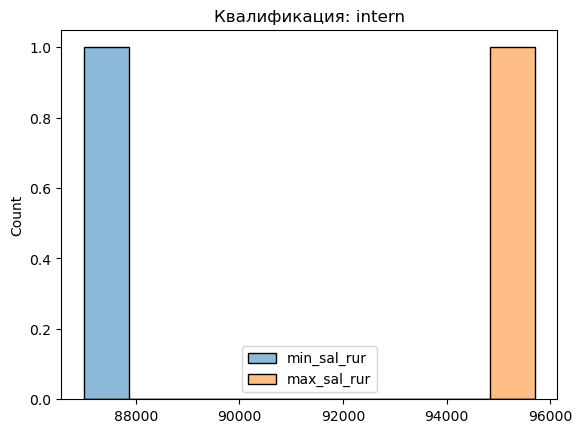

,%,"median salary min, krur","median salary max, krur",0-1,1-3,3-6,> 6
lead,9.0,327.2,404.2,1.0,14.0,61.0,24.0
senior,16.0,287.4,449.1,1.0,5.0,75.0,18.0
middle,6.0,160.0,NaN,NaN,41.0,57.0,2.0
junior,2.0,70.0,NaN,27.0,73.0,NaN,NaN
intern,1.0,87.0,95.7,83.0,17.0,NaN,NaN


In [ ]:
for grade in grades:
    grade_temp = vacs_clean.position_title.str.contains(grade)
    grades_disribution[grade] = grade_temp.value_counts(
        normalize=True).loc[True].round(2)*100
    median_sal_grade_min[grade] = vacs_clean[grade_temp].min_sal_rur.median(
    )/1000
    median_sal_grade_max[grade] = vacs_clean[grade_temp].max_sal_rur.median(
    )/1000
    expirience_distribution[grade] = vacs_clean[grade_temp].experience.value_counts(
        normalize=True).round(2)*100
    try:
        hists = sns.histplot(vacs_clean.loc[grade_temp,
                                            ['min_sal_rur', 'max_sal_rur']],
                             kde=True, bins=10).set_title(f'Квалификация: {grade}')
        plt.show()
    except:
        pass
grade_sal = pd.DataFrame([grades_disribution,
                          median_sal_grade_min,
                          median_sal_grade_max],
                         index=['%', 'median salary min, krur',
                                'median salary max, krur']).T.round(1)

sals=pd.concat([grade_sal, pd.DataFrame(expirience_distribution).T], axis=1)
sals

Выводы:

1) Самая востребованная квалификация -сениоры, далее идёт лиды.

2) Наименее востребованны интерны и джуниоры. Оклад интерна выше джуниорского, скорее всего это эффект непредставительности этой малой выборки.

3) На позицию интерна могут претендовать сотрудники без опыта работы, только 17% работодателей требует опыт работы от года до трёх лет.

4) С позицией джунироа наоборот, сотрудников без опыта рассматривают только 27% компаний, =остальным необходим опыт от года до трёх лет.

5) На позицию мидл могут претендовать только специаисты с опытом работы 1-3 г, и 3-6 лет.

6) Как это не парадоксально на специалисты с опытом 1-3 года, имеют шансы (14%) быть рассмотренными на позицию уровня lead.

7) Нижняя медианая граница  зарплаты максимальна для уровня lead, но верхняя медианная граница должостного оклада, выше у  сениора.

### Общие выводы по исследованию

1) Доработана и исправлена  программа парсинга и извлечения данных по зарплатам Data Engineer в Москве.

2) Полученные даные позволяют оценить характер распределения зарплат по позициям связанным с data engineering,а также по уровням квалификации и стажам.

3) анные несбалансированы по классу стажа, очень мало вакансий с требуемым опытом 0-1 и 1-3 года, а также свыше 6 лет. подавляющее большинство вакансий прдусматривает стаж 1-6 лет.

4) Наиболее перспективные дя начинающих вакансии относятся к позициям ML Engineer, Data Engineer Developer.

5) В дальнейшем планируется охватить весь спектр профессий смежных с Data Engineering и поспытаться увеличить количество записей с указанием зарплаты, для того чтобы можно было построить модели предсказания зарплат исходя из позиции, стажа и квалификации.

6) Также планируется более детальное изучение описаний вакансий для выявления особенностей функционала, потенциально связанных с оплатой труда.